<h1 style="text-align: center; font-family: 'Arial', sans-serif; color: #2c3e50;">
  <strong>Jaca 2025 Summer School: Introduction to Neural Networks Programming and Applied Artificial Intelligence</strong>
</h1>

<h2> July 1-4, 2025 </h2>


---



> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Course coordinator </strong><br>
  David Gonzalez (gonzal@unizar.es)
</p>

> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Authors </strong><br>
  </p>
  Carlos Bermejo-Barbanoj
  </p>
  Alicia Tierz
  </p>
  Mikel M. Iparraguirre
  </p>
  Lucas Tesán
  </p>
  </p>
  Pau Urdeitx


---




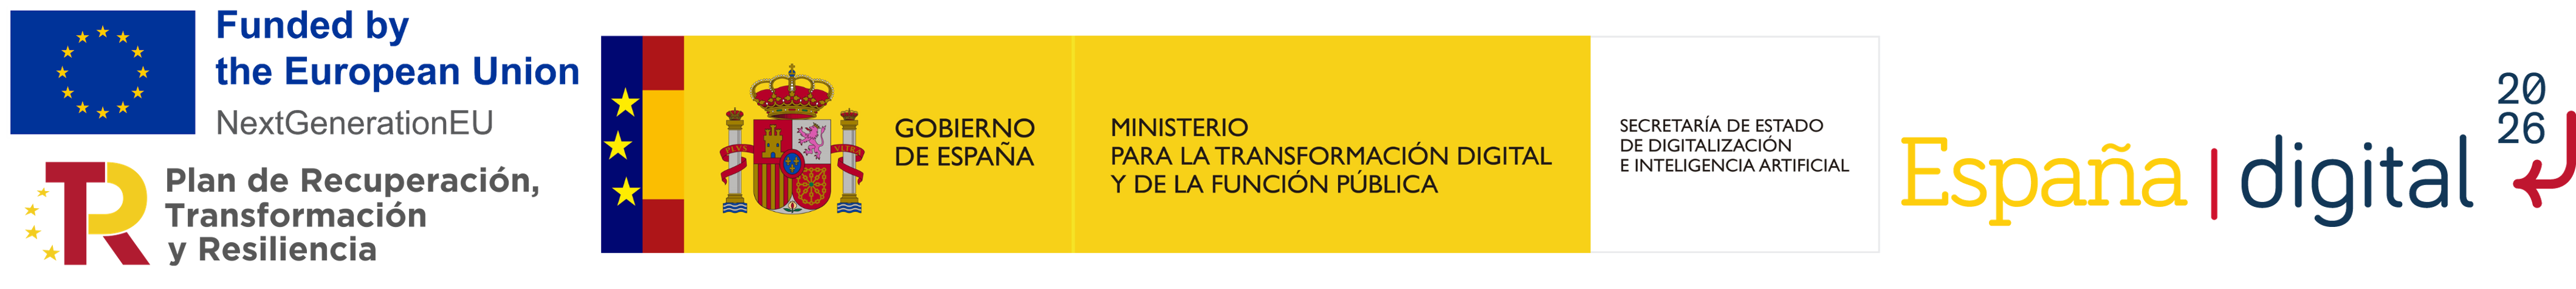

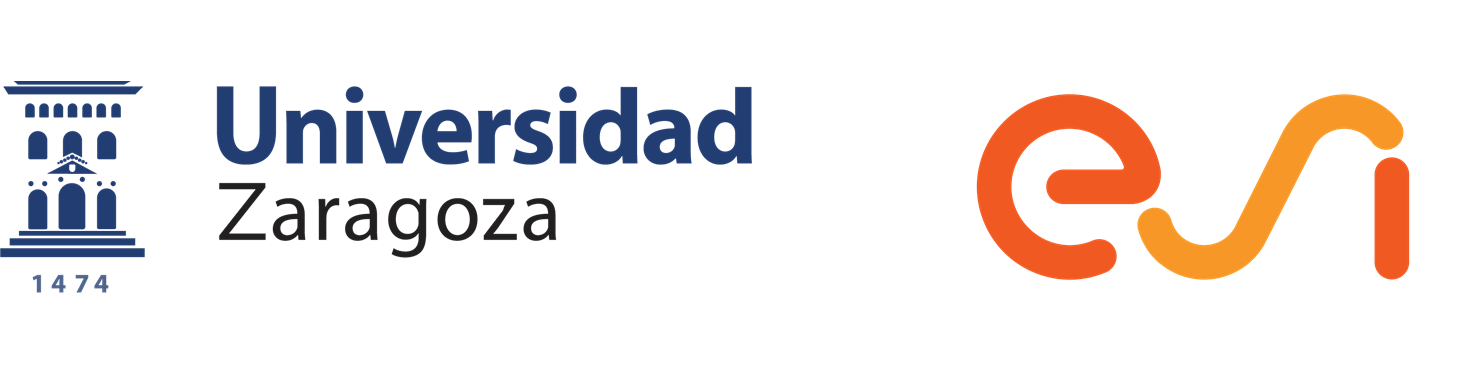

# Chapter 6 Model Optimization: Advanced Training Techniques
---


> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Lecture</strong><br>
  Mikel M. Iparraguirre
</p>

> <p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Notebook Authors</strong><br>
  </p>
  Mikel M. Iparraguirre
    </p>
  Pau Urdeitx
</p>


---
This notebook assumes familiarity with Python and basic programming concepts. Prior knowledge of neural networks is helpful but not required.

# 🔎 Deep Dive into Model Selection & Hyperparameter Tuning in Deep Learning

Welcome to this hands-on notebook where we explore the art and science of building performant deep learning models through **model selection**, **hyperparameter tuning**, and **regularization techniques**.

Using the classic **MNIST handwritten digits dataset**, we'll walk through a practical pipeline that mirrors real-world machine learning workflows. This notebook isn’t just about getting high accuracy—it’s about understanding the *why* behind each design choice.

---

### 🚀 How to Think Like a Good AI Engineer

- 📊 **Understand Your Data**: Analyze and **visualize data** to define our **machine learning problem**  
- ✂️ **Data Splitting**: Best practices for dividing data into training, validation, and test sets  
- ⚡ **Model Design**: How to define a neural network from scratch  
- 🧪 **Model Selection**: The impact of key **hyperparameters** like learning rate, batch size, and number of layers  
- 🛡️ **Regularization Techniques**: How to improve **generalization** using **Dropout** and **Early Stopping**
---



## 📊 Understand Your Data


The **MNIST dataset** is a collection of 70,000 grayscale images of handwritten digits (0–9), each sized 28×28 pixels. It is widely used as a benchmark for image classification tasks in machine learning.

In this notebook, we load a small **fraction** of the MNIST dataset to speed up experimentation and reduce training time, while still preserving meaningful insights.


#### ⏳ Loading MNIST dataset

In [ ]:
!pip install -q pytorch_lightning
!pip install -q wandb

In [ ]:
import os
import wandb
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from types import SimpleNamespace

In [ ]:
def load_mnist(train=True):
    transform = transforms.ToTensor()
    mnist_train_full = datasets.MNIST(os.getcwd(), train=train, download=True, transform=transform)

    # Extract images and labels as tensors
    data = torch.stack([mnist_train_full[i][0] for i in range(len(mnist_train_full))])
    targets = torch.tensor([mnist_train_full[i][1] for i in range(len(mnist_train_full))])
    print()
    print(f"Loaded MNIST subset with {len(data):,} images.")
    print(f"Image tensor shape: {data.shape}")
    print(f"Labels tensor shape: {targets.shape}")

    return data, targets

In [ ]:
images, targets = load_mnist()

### 👀 Visualising MNIST dataset

In [ ]:
def visualize_dataset_sample(idx=0):
    """This function visualizes a
    single sample from the dataset by index."""
    # Plot
    plt.figure(figsize=(3,3))

    image = images[idx].squeeze()
    label = targets[idx].item()

    plt.imshow(image, cmap='gray')
    plt.title(f"Lable={label}", fontsize=10)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def plot_label_distribution(labels, title="Label Distribution"):
    """Plots a histogram of label counts to visualize class balance."""
    # Convert tensor to numpy for plotting
    label_array = labels.numpy()

    # Create histogram
    plt.figure(figsize=(8, 4))
    plt.hist(label_array, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')

    # Add text and grid
    plt.title(title)
    plt.xlabel("Digit Label")
    plt.ylabel("Number of Samples")
    plt.xticks(range(10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Visualize one sample and the labels distribution

In [ ]:
# visualize one sample
smaple_index = 5
visualize_dataset_sample(idx=smaple_index)
# Call the function on the full set or on splits
plot_label_distribution(targets)

## ✂️ Dataset Split: Making a Train/Validation set

**Proper data splitting** is essential to ensure that the model is trained and validated on **distinct, representative subsets** of the data. This helps to:
- 🔒 **prevent data leakage**
- ⚖️ **reduce overfitting**
- 📈 **produce reliable performance estimates**

We start with the available dataset. It’s important to realize that **this is all the data we have**, and we must **decide how to split it** into training and validation sets.

To do this, we use `sklearn.model_selection.train_test_split`, which provides a flexible way to divide the data while optionally maintaining label distribution using **stratification**.

🧠 **Key point:**  
Choosing the right split ratio (e.g., 80/20 or 70/30) is part of the design decisions **students must make**. This decision impacts training quality and validation reliability of the model selection proces.

Let’s now define our split!



In [ ]:
# Define split ratio
validation_ratio = 0.25 # TODO

# Perform the split with stratification to maintain label balance
X_train, X_val, y_train, y_val = train_test_split(images, targets, test_size=validation_ratio, stratify=targets, random_state=42)

# Set as TensorDatasets
reduction_train = 0.1  # reduce training data
train_dataset_full = TensorDataset(X_train, y_train)
train_dataset = TensorDataset(X_train[:int(len(X_train)*reduction_train)], y_train[:int(len(X_train)*reduction_train)])
val_dataset = TensorDataset(X_val, y_val)

# Check the size of the splits
print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

# visualize distribution validation after splitting
plot_label_distribution(y_val, title='Distribution targets Train')
plot_label_distribution(y_val, title='Distribution targets Valid')

## ⚡ Model Architecture

In this notebook, we use a **fully connected neural network (MLP)** to classify handwritten digits from the MNIST dataset.

### 🧠 Model Structure:
- The network starts by **flattening** the 28×28 input image.
- Then, it passes through one or more **hidden layers** with **ReLU activations**.
- Finally, it outputs **10 logits** (one for each digit class).

This structure is simple but effective for small image datasets like MNIST, and it allows us to explore the effect of **hyperparameters** such as:
- Number of **hidden units**
- Number of **layers**
- **Learning rate**
- **Optimizer** type (SGD or Adam).


In [ ]:
# 1. Define the LightningModule
class LitMNIST(pl.LightningModule):
    def __init__(self, hidden=128, layers=2, lr=1e-3, dropout=0., optimizer='Adam'):
        super().__init__()
        # save hyperparameters
        self.save_hyperparameters()

        # set architecture
        model = [torch.nn.Flatten(),
                torch.nn.Linear(28 * 28, hidden),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=dropout)]  # Dropout after each ReLU

        for i in range(layers - 2):
            model.append(torch.nn.Linear(hidden, hidden))
            model.append(torch.nn.ReLU())
            model.append(torch.nn.Dropout(p=dropout))  # Dropout after each ReLU

        model.append(torch.nn.Linear(hidden, 10))  # Final output layer without dropout

        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        if self.hparams.optimizer == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

    def predict_digit(self, x: torch.Tensor):
        self.eval()
        with torch.no_grad():
            logits = self(x)
            probs = F.softmax(logits, dim=1)
            pred = torch.argmax(probs, dim=1)
        return pred, probs[0][pred]

## 🧪  Hyperparameter Optimization: W&B


When training machine learning models, **finding the best hyperparameter configuration** is crucial for achieving good performance. Instead of manually testing every combination, tools like **Weights & Biases (W&B)** automate this process by performing an efficient **search over the configuration space**.

With W&B, you can:

- **Define a search space** of hyperparameters
- **Run multiple training experiments** exploring different hyperparameter combinations.
- **Track and visualize results** in real-time on an interactive dashboard.
- **Identify the best configuration** based on your chosen evaluation metric (e.g., validation accuracy).

This approach helps you **systematically optimize your model**!

It’s essential to set these three components clearly before starting the hyperparameter optimization.

1. **Hyperparameter search space** — specifying which parameters to explore and their possible values or ranges.  
2. **Optimization goal** — choosing the metric to maximize or minimize (e.g., validation accuracy).  
3. **Effective search method** — selecting how to explore the space (e.g., random search, grid search, Bayesian optimization).


Here is the hyperparameter configuration space we explore in this notebook:

| Hyperparameter           | Description                           | Example Values / Range    |
|-------------------------|-------------------------------------|--------------------------|
| **Number of Hidden Units** | Number of neurons in each hidden layer | 4 to 128 or to 1024               |
| **Number of Layers**       | Total hidden layers in the network     | 2, 4, 8                  |
| **Learning Rate (lr)**     | Step size for optimizer updates        | 1e-6 to 1e-1             |
| **Optimizer Type**         | Algorithm to update weights             | SGD, Adam                |


### 🐙 Sweep configuration

To run a hyperparameter sweep with Weights & Biases (W&B), we must define a dictionary specifying:

- The **effective search method**: how W&B explores the hyperparameter space (e.g., `"random"`, `"grid"`, `"bayes"`).
- The **optimization goal**: the metric W&B will monitor and either maximize or minimize (e.g., `"metric_acc"`, `"loss"`).
- The **hyperparameter search space**: the parameters to tune, their possible values or distributions.

Here is an example sweep configuration dictionary for W&B:

In [ ]:
hyperopt_sweep = {
    
    # Searching method
    "method": "bayes", # G1: "random" | G2: "grid" | G3: "bayes" | G4: "student-search"
    
    # Hyperparameter Optimization Goal
    "metric": {
        "name": "val_acc", # "val_loss", "train_loss", "val_acc", "train_acc"
        "goal": "maximize", # "maximize", "minimize"
    },
    
    # Hyperparameter Search Space
    "parameters": {
        "lr": {
           "distribution": "log_uniform_values",
           "min": 1e-5,
           "max": 1e-1
        },
        "hidden": {
            "distribution": "q_uniform",
            "q": 8,
            "min": 16,
            "max": 512
        },
        
        "layers":{
            "values": [2, 4, 8],
        },
        "optimizer": {
            "values": ["Adam", "SGD"], 
        }
    }
}


### 🔀 Training and Evaluating Sampled Hyperparameter Sets

Weights & Biases (W&B) **samples hyperparameter configurations** from the defined configuration space to train the model and evaluate its performance.

Each sampled configuration is used to run a full training cycle, logging metrics such as loss and accuracy, so we can compare different settings and identify the best-performing combination.


In [ ]:
def training_optimization(config=None):
    
    # Called by W&B sweep
    with wandb.init() as run:
        args = run.config
    
    # Logger
    wandb_logger = WandbLogger(
        project="mnist-sweep",
        name=f"layers={args.layers}_hidden={args.hidden}_lr={args.lr:.0e}_Opt={args.optimizer}",
        log_model=False
    )

    # Set seed
    pl.seed_everything(52, workers=True)

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    # Model instantiation
    model = LitMNIST(hidden=args.hidden, layers=args.layers, dropout=0, lr=args.lr, optimizer=args.optimizer)

    # Save best trained model
    checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)

    # Trainer
    trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        max_epochs=5,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
        deterministic=True,
        num_sanity_val_steps=0
    )

    # Fit
    trainer.fit(model, train_loader, val_loader)

    return model

### 🚀 Launch Hyperparameter Optimization

Once the sweep configuration is defined, we **create the sweep** in W&B, which sets up the experiment with the specified search space and optimization criteria.

Next, we **run the sweep agent**, which automatically samples hyperparameter configurations and executes the training function for each trial. By setting `count`, we control how many configurations to evaluate.

This process allows us to efficiently explore many hyperparameter combinations, track results, and identify the best-performing model settings.


In [ ]:
# Create the sweep
hyperparam_optimization = wandb.sweep(hyperopt_sweep, project="mnist-hyperOpt")

# Run the agent
wandb.agent(hyperparam_optimization, function=training_optimization, count=20)

### 🚀 Final Training with Best Hyperparameters and Early Stopping

After completing model selection, we now **retrain the model using the best hyperparameters** we found during tuning.  
This ensures that our final model builds on the most effective configuration identified.

To further improve generalization and avoid overfitting, we apply **Early Stopping** during training:

- ⏹️ **Early Stopping**: Monitors validation performance and **automatically stops training** when the model stops improving.  
  This prevents overfitting, reduces training time, and helps the model generalize better to unseen data.

> ✅ With this setup, we make the most of our tuned hyperparameters while also controlling overfitting using Early Stopping.


#### Best hyperparamters

In [ ]:
# best found hyperparamters
hidden = 512
layers = 2
lr = 1e-3
optimizer = "Adam"

#### Early stopping callback

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

# early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",     # Metric to monitor
    min_delta=0.00,         # Minimum change to qualify as improvement
    patience=5,            # Epochs with no improvement after which training will be stopped
    verbose=True,           # Print early stopping messages
    mode="min"              # "min" for loss, "max" for accuracy or similar
)

#### Train model

In [ ]:
# Logger
wandb_logger = WandbLogger(
    project="mnist-best-hyperparam",
    name=f"layers={layers}_hidden={hidden}_lr={lr:.0e}_Opt={optimizer}",
    log_model=False
)

# Set seed
pl.seed_everything(52, workers=True)

# Data Loaders
train_loader = DataLoader(train_dataset_full, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Model instantiation
model = LitMNIST(hidden=hidden, layers=layers, 
                 lr=lr, optimizer=optimizer, dropout=0.2)

# Save best trained model
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)


# Trainer
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    max_epochs=50,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping],
    deterministic=True,
    num_sanity_val_steps=0
)

# Fit
trainer.fit(model, train_loader, val_loader)

# 🧪 Final Evaluation with Best Hyperparameters

After experimenting with different settings, we selected the best combination of hyperparameters.  
We then trained the model for longer using **Early Stopping** to prevent overfitting for regularization.

In this final step, we evaluate the trained model on the **MNIST test set** using `accuracy_score` from `sklearn.metrics`.

This allows us to measure the model’s generalization performance on unseen data.

The final test accuracy is printed below.

In [ ]:
from sklearn.metrics import accuracy_score

images_test, tagets_test = load_mnist(train=False)
predictions_test, _ = model.predict_digit(images_test)

acc = accuracy_score(predictions_test, tagets_test)

# Print result
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")
print(f"Evaluated on {len(tagets_test):,} test images.")

# 📱 Handwritten Digit Classifier App

### Let's test the OUR model! 

We've now built an interactive **digit classification app** using our trained model!  
This app can take an image of a **handwritten digit (0–9)** and predict what number it represents.

It uses the model we've trained on the MNIST dataset, which has learned to recognize digit patterns from thousands of examples.

With just a single input image, the app returns:

- 🔢 The **predicted digit**
- 📊 The **confidence score** of the prediction

> ✅ This is a practical demonstration of how deep learning models can be deployed in real-world applications like OCR (Optical Character Recognition), banking, postal systems, and more.


#### Classifier App

In [ ]:
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps

class DigitDrawer:
    def __init__(self, model, size=280):
        self.model = model.eval()
        self.size = size  # Canvas size (280x280 for MNIST scaling)
        self.window = tk.Tk()
        self.window.title("Draw a digit")

        self.canvas = tk.Canvas(self.window, width=self.size, height=self.size, bg='black')
        self.canvas.pack()

        self.image = Image.new("L", (self.size, self.size), 0)
        self.draw = ImageDraw.Draw(self.image)

        self.canvas.bind("<B1-Motion>", self.paint)

        # Buttons Frame
        button_frame = tk.Frame(self.window)
        button_frame.pack()

        self.done_button = tk.Button(button_frame, text="Done", command=self.predict_digit)
        self.done_button.grid(row=0, column=0, padx=5, pady=5)

        self.reset_button = tk.Button(button_frame, text="Reset", command=self.reset_canvas)
        self.reset_button.grid(row=0, column=1, padx=5, pady=5)

        self.result_label = tk.Label(self.window, text="", font=("Arial", 20))
        self.result_label.pack()

    def paint(self, event):
        x1, y1 = (event.x - 10), (event.y - 10)
        x2, y2 = (event.x + 10), (event.y + 10)
        self.canvas.create_oval(x1, y1, x2, y2, fill='white', outline='white')
        self.draw.ellipse([x1, y1, x2, y2], fill=255)

    def reset_canvas(self):
        self.canvas.delete("all")
        self.image = Image.new("L", (self.size, self.size), 0)
        self.draw = ImageDraw.Draw(self.image)
        self.result_label.config(text="")  # Clear prediction result

    def preprocess_image(self):
        img = self.image.copy()
        img = img.resize((28, 28))                # Resize to MNIST size
        img = transforms.ToTensor()(img)          # shape: [1, 28, 28], values in [0, 1]
        img = img.unsqueeze(0)                    # shape: [1, 1, 28, 28]
        return img

    def predict_digit(self):
        input_tensor = self.preprocess_image()
        prediction, probs = model.predict_digit(input_tensor)
        self.result_label.config(text=f"Predicted Digit: {prediction.item()} Probability: {probs.item()}")

app = DigitDrawer(model)
app.window.mainloop()

# **References**
[1]. Ian Goodfellow and Yoshua Bengio and Aaron Courville. *Deep Learning*. Deep Learning (2016). [http://www.deeplearningbook.org](http://www.deeplearningbook.org)

[2]. Weights & Biases Documentation. *Official guide and API reference for experiment tracking, sweeps, and visualization tools.*  
   [https://docs.wandb.ai](https://docs.wandb.ai)



# **License**

Creative Commons Attribution-NonCommercial 4.0 International License

You are free to:
- Share — copy and redistribute the material in any medium or format
- Adapt — remix, transform, and build upon the material

Under the following terms:
- Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
- NonCommercial — You may not use the material for commercial purposes.

No additional restrictions — You may not apply legal terms or technological measures that legally restrict others from doing anything the license permits.

Full license details: https://creativecommons.org/licenses/by-nc/4.0/